# Advanced Lane Finding

The purpose of this code is to calibrate our camera using the 20 chessboard images provided.

A chessboard is used for camera calibration since its regular patterns of high contrast make it easy to detect automatically. So, if we use our camera to take multiple pictures of chessboard agaisnt a flat surface, then we will be able to detect any distortion by looking at the difference between the appartent size and shape of the squares of the chessboard pattern.

We will start by importing all relevant libraries such as opencv, numpy required.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import natsort
import pickle

### Display a couple of random test images

Let us display a random image and get its details, such as type, shape, no. of chanels information. We will display one image from daylight and night scenarios.

<Figure size 432x288 with 0 Axes>

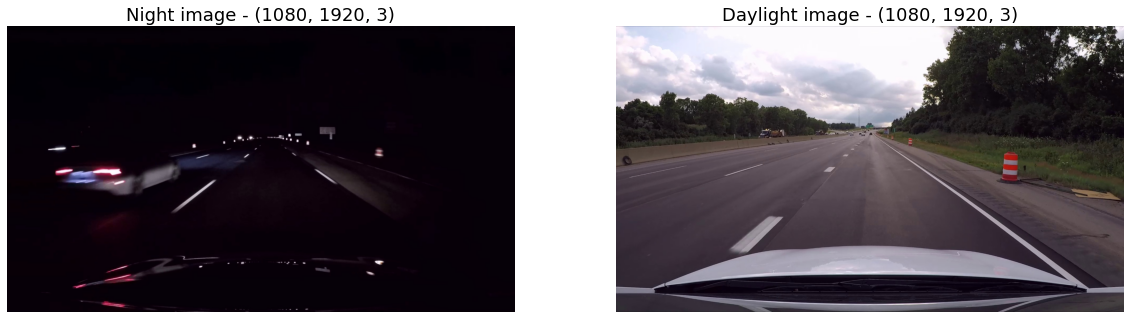

In [2]:
# display a couple of random images

sample_image1 = mpimg.imread("test_images/test1.jpg")
sample_image2 = mpimg.imread("test_images/test7.jpg")

plt.figure(1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample_image1)
ax1.set_title(f'Night image - {sample_image2.shape}', fontsize=18)
ax1.axis('off')
ax2.imshow(sample_image2)
ax2.set_title(f'Daylight image - {sample_image2.shape}', fontsize=18)
ax2.axis('off')
plt.show()


## Calibrate Camera Function

There are two main steps to this process: use chessboard images to obtain image points and object points, and then use the OpenCV functions cv2.calibrateCamera() and cv2.undistort() to compute the calibration and undistortion.

More information on the use of these functions can be found on the OpenCV documentation website at the following location:

[cv2.calibrateCamera()](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#calibratecamera)

[cv2.undistort()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=undistort#cv2.undistort)

Camera calibration for this project is already performed using a set of chessboard corner images in a separate jupyter notebook [camera_calculations.ipynb](./camera_calculations.ipynb)
Here is a sample image -

![image](./readme_images/test_undistortion.jpg)

## Thresholding Functions

In this section, I have written functions for calculating parameters such as Sobel Intensity Gradients, Gradient magnitude, gradient direction, hue, lightness, saturation and applying threshold values to idetify lanelines in images. Each of these functions will extract a binary image with the applied threshold values.

The idea behind writing different functions is that there is little extra effort involved and it is possible to use multiple combinations of these filters to achieve the best result.

In [3]:
# Thresholding functions
# since we have evaludated earlier that HLS gives good image filtering results
def hue_select(img, thresh = (0,255)):

    # 1. convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2. apply threshold to s channel
    h_channel = hls[:,:,0]

    # 3. create empty array to store the binary output and apply threshold
    hue_image = np.zeros_like(h_channel)
    hue_image[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1

    return hue_image

def lightness_select(img, thresh = (120,255)):
    
    # 1. Convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # 2. Apply threshold to s channel
    l_channel = hls[:,:,1]

    # 3. Create empty array to store the binary output and apply threshold
    lightness_image = np.zeros_like(l_channel)
    lightness_image[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1

    return lightness_image


def saturation_select(img, thresh = (100,255)):

    # 1. convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # 2. apply threshold to s channel
    s_channel = hls[:,:,2]

    # 3. create empty array to store the binary output and apply threshold
    sat_image = np.zeros_like(s_channel)
    sat_image[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return sat_image


def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0,255)):

    # 1. Applying the Sobel depending on x or y direction and getting the absolute value
    if (orient == 'x'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if (orient == 'y'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))

    # 2. Scaling to 8-bit and converting to np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 3. Create mask of '1's where the sobel magnitude is > thresh_min and < thresh_max
    sobel_image = np.zeros_like(scaled_sobel)
    sobel_image[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sobel_image


def mag_sobel(img, sobel_kernel=3, thresh = (0,255)):

    # 1. Applying the Sobel (taking the derivative)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # 2. Magnitude of Sobel
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)

    # 3. Scaling to 8-bit and converting to np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))

    # 4. Create mask of '1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sobel_mag_image = np.zeros_like(scaled_sobel)
    sobel_mag_image[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sobel_mag_image


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1. Applying the Sobel (taking the derivative)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 2. Take absolute magnitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 3. Take Tangent value
    sobel_orient = np.arctan2(abs_sobely, abs_sobelx)
    
    # 4. Create mask of '1's where the orientation magnitude is > thresh_min and < thresh_max
    dir_image = np.zeros_like(sobel_orient)
    dir_image[(sobel_orient >= thresh[0]) & (sobel_orient <= thresh[1])] = 1
    
    return dir_image

### Combined Thresholding Function

Using this function, we combine different threshold values together in a binary image. The images saved for different thresholds are saved in separate folders within the folder ***output_images/*** as per the name of the filter.
Following list of folders are created for storing binary thresholded images:


| Image Folder Name  | Stored Image details |
| :---: | :---: | 
| output_images/test_images_gray | Grayscale Images |
| output_images/test_images_dir_binary | Sobel Gradient Direction |
| output_images/test_images_h_binary | Hue channel threshold |
| output_images/test_images_l_binary | Lightness channel threshold |
| output_images/test_images_s_binary | Saturation channel threshold |
| output_images/test_images_gradx_binary | Sobel gradient in X direction |
| output_images/test_images_hls_plots | Separated Channel Plots |
| output_images/test_images_undistorted | Undistorted Images |
| output_images/test_images_thresholded | Combined Threshold |
| output_images/test_images_binary_warped | Thresholded, Undistorted and Warped|
| output_images/test_images_masked | Thresholded, Undistorted and Masked |

##### Important:
**Within the combined thresholding function, we call other individual thresholding functions starting from line 13 onwards. The thresholding parameters of all these functions need to be set here.**

We also apply a masking threshold to our image to isolate only the region of interest and remove unneccessary pixel information such as scenery and problematic objects such as vehicle hood.

In [4]:
### Combined Thresholding Function

def combined_threshold(img):

    # convert to hls format and extract channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # applying thresholding and storing different filtered images

    h_binary = hue_select(img, thresh = (100, 255))
    l_binary = lightness_select(img, thresh = (120, 255))
    s_binary = saturation_select(img, thresh = (100, 255))

    ksize = 9
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    dir_binary = dir_threshold(s_channel, sobel_kernel=ksize, thresh=(0.7, 1.3))
    # grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(20, 100))

    # creating an empty binary image
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((gradx == 1) | (s_binary == 1)) & ((l_binary == 1) & (s_binary == 1))] = 1
    # plt.imshow(combined_binary)

    # apply region of interest mask
    height, width = combined_binary.shape
    mask = np.zeros_like(combined_binary)
    region = np.array([[0, height-1], [int(width/2), int(height/2)], [width-1, height-1]], dtype=np.int32)
    # print(region)
    cv2.fillPoly(mask, [region], 1)

    masked = cv2.bitwise_and(combined_binary, mask)
    
    # This section is only for saving the separated hls plots.
    # This is commented out after running it once...
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 10))
    ax1.imshow(h_binary)
    ax1.set_title('Hue', fontsize=20)
    ax2.imshow(l_binary)
    ax2.set_title('Lightness', fontsize=20)
    ax3.imshow(s_binary)
    ax3.set_title('Saturation', fontsize=20)
    ax4.imshow(gradx)
    ax4.set_title('X-Gradient', fontsize=20)
    
    
    # save hls separation plots
    plt.savefig(('test_images_output/test_images_hls_plots/hls-plots-'+ i), cmap = 'gray') 
    
    # save individual images for HSL plots, gradients, magnitude and direction
    mpimg.imsave(('test_images_output/test_images_gray/gray-' + i), gray, cmap = 'gray')
    mpimg.imsave(('test_images_output/test_images_h_binary/h_binary-' + i), h_binary, cmap = 'gray')
    mpimg.imsave(('test_images_output/test_images_l_binary/l_binary-' + i), l_binary, cmap = 'gray')
    mpimg.imsave(('test_images_output/test_images_s_binary/s_binary-' + i), s_binary, cmap = 'gray')
    mpimg.imsave(('test_images_output/test_images_gradx_binary/gradx-' + i), gradx, cmap = 'gray')
    mpimg.imsave(('test_images_output/test_images_dir_binary/direction-' + i), dir_binary, cmap = 'gray')

    # saving combined thresholded binary image
    mpimg.imsave(('test_images_output/test_images_thresholded/combined-' + i), combined_binary, cmap = 'gray')

    # saving masked images
    mpimg.imsave(('test_images_output/test_images_masked/masked-' + i), masked, cmap = 'gray')
    # end of saving images section, comment out above section after saving the images
    
    
    return masked

### Perspective Transform

After applying the thresholds, isolating the regions of interest and getting our binary image with identified lanelines, we apply the perspective transform to the image.
We do this using [**cv2.getPerspectiveTransform(src, dst)**](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#getperspectivetransform).

This function enables us to obtain a birds-eye view of the lanelines (from top) using which we will in our calculations for obtaining lane curvatures.

In [5]:
# function for applying perspective view on the images
def perspective_view(img):

    img_size = (img.shape[1], img.shape[0])

    # image points extracted from image approximately
    bottom_left = [210, 720]
    bottom_right = [1100, 720]
    top_left = [570, 470]
    top_right = [720, 470]

    src = np.float32([bottom_left, bottom_right, top_right, top_left])

    pts = np.array([bottom_left, bottom_right, top_right, top_left], np.int32)
    pts = pts.reshape((-1, 1, 2))
    # create a copy of original img
    imgpts = img.copy()
    cv2.polylines(imgpts, [pts], True, (255, 0, 0), thickness = 3)

    # choose four points in warped image so that the lines should appear as parallel
    bottom_left_dst = [320, 720]
    bottom_right_dst = [920, 720]
    top_left_dst = [320, 1]
    top_right_dst = [920, 1]

    dst = np.float32([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst])

    # apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)

    # compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    # warp the image using perspective transform M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

### Getting images from a directory

In [6]:
# Let us test our functions on given test images
directory = os.listdir("test_images/")
# sorting the images based on ids
directory = natsort.natsorted(directory)
print(directory)

['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg', 'test7.jpg', 'test8.jpg', 'test9.jpg']


### Load Saved Pickle Data

By printing matrix data from pickle here, we will confirm that undistortion matrices have been saved correctly.

In [7]:
file = open('pickle/dist_pickle.p', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:')

mtx, dst = data.values()

print("Saved distortion matrix coeffiencient:")
print("mtx = ", mtx)
print()
print("dst = ", dst)


Showing the pickled data:
Saved distortion matrix coeffiencient:
mtx =  [[1.11976774e+03 0.00000000e+00 9.64549015e+02]
 [0.00000000e+00 1.11133051e+03 7.25644361e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dst =  [[-0.26776597  0.11511928 -0.0013741  -0.00063393 -0.02582954]]


### Run functions for Combined Thresholding and Perspective Transform on test images

In [ ]:
for i in directory:

    img = mpimg.imread(os.path.join("test_images/", i))

    # undistort the image
    undist = cv2.undistort(img, mtx, dst, None, mtx)
    # mpimg.imsave(('test_images_output/test_images_undistorted/undistorted-'+i), undist, cmap = 'gray')
    
    # apply combined threshold and get the masked thresholded image
    thresholded = combined_threshold(undist)

    binary_warped, M, Minv = perspective_view(thresholded)
    # mpimg.imsave(('test_images_outputs/test_images_binary_warped/binary_warped-'+i), binary_warped, cmap = 'gray')

#### Save mtx data for one image and plot the image

We will plot the masked region for better visualization. The following plot gives us details across different channels and thresholding levels for one image.

In [ ]:
# read in an image
img = mpimg.imread("test_images/test2.jpg")

# undistort the original image using stored values from pickle
undist_original = cv2.undistort(img, mtx, dist, None, mtx)

# apply perspective view on the image
warped_original, M, Minv = perspective_view(undist_original)

# apply combined threshold
combined_threshold_img = combined_threshold(undist_original)

# apply perspective transform on the thresholded image
warped, M, Minv = perspective_view(combined_threshold_img)

plt.figure(2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist_original)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

plt.figure(2)
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(warped_original)
ax3.set_title('Warped Original', fontsize=20)
ax4.imshow(warped, cmap = 'gray')
ax4.set_title('Warped Masked', fontsize=20)
plt.show()

# save new pickle for test images from car's camera
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["M"] = M
dist_pickle["Minv"] = Minv
pickle.dump(dist_pickle, open("pickle/test_images_dist_pickle.p", "wb"))

### Finding Lane Pixels
#### Lane Finding Method: Peaks in a histogram

After applying calibration, thresholding, and a perspective transform to a road image, we have a binary image where the lane lines stand out clearly. However, we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

We define this using the hist function from NumPy. With this histogram we are adding up the pixel values along each column in the image. In our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. We should get a output that looks as shown below.

From here, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame. We use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go. Here is how it is done -


In [ ]:
# first we will demo the histogram function
img = mpimg.imread('test_images_output/test_images_binary_warped/binary_warped-straight_lines1.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    
    return histogram

# Create histogram of image binary activations

histogram = hist(img[:,:,1])
print(img.shape)

# Visualize the resulting histogram
plt.figure(3)
plt.plot(histogram)
plt.title('Plotted Histogram')

plt.figure(4)
plt.imshow(img)
plt.title('Binary Warped Image')


## PIPELINE
### (for detecting lanelines and calculating road curvature


Here, we will establish a pipeline for detecting lanelines. We have created a class in a separate file *class_lanelines.py* which stores lanelines as objects along with their properties such as left and right fits.


![image](readme_images/color-fit-lines.jpg)

---
1. We use the approach of sliding boxes from bottom to top in our histogram to detect laneline pixels and get their co-ordinates.
2. Once we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line. We store the x and y co-ordinates of these pixels in lists leftx, lefty, rightx and righty.
3. After fitting a 2nd order polynomial using the NumPy function [np.polyfit()](https://numpy.org/doc/1.18/reference/generated/numpy.polyfit.html), we plot the lines using a linspace model on our image.
4. Then, we calculate the radius of curvature using the following mathematical equations. This gives us road curvature radius in pixels. -

![image](readme_images/formulae.png)

5. We convert the road curvature from pixels to meters.

### Lanelines Function

This function contains code for detecting lanelines bases on our approach as explained above. Later on, this function will be used repeatedly for detecting lanelines in our video stream.

I have also included functionality here to store previous lanelines data (2nd order equations) so that they can be used for successive frames. The variables ***avg_left_fit*** and ***avg_right_it*** are calculated based on the measurements of previous 12 frames. This helps the code to fit lanelines for the current frame even if they are not detected.

For a vehicle traveling at maximum speed of 80mph (as per legal limits on most roads in US), the vehicle travels about 35 m/sec. The camera records the video stream at 30 frames/second. Hence, for our weighted averaging of 12 frames/second, the vehicle moves just about 14m (about 3 car lengths) and can be approximated. It can be safely assumed that lanelines will not change significantly during such a smaller distance. This value will be even smaller for lower speeds. Hence, it is safe for approximation.

In [ ]:
def advanced_lanelines(img):

    # undistort the original image using stored values from pickle
    undist_original = cv2.undistort(img, mtx, dist, None, mtx)
    # apply perspective view on the image
    warped_original, M, Minv = perspective_view(undist_original)

    # apply combined threshold
    threshold = combined_threshold(img)
    # undistort the thresholded image
    undist_thresholded = cv2.undistort(threshold, mtx, dist, None, mtx)
    # apply perspective transform on the thresholded image
    warped, M, Minv = perspective_view(undist_thresholded)

    # these will be empty for the first iteration and they will store the values of lane fits from previous iterations
    # declaring lane fits as global variables so that they can be modified from anywhere in the code
    
    # list storing left and right lanefit values from previous frames
    global prev_left_fits
    global prev_right_fits

    # average of previous 10 lanefits
    global average_left_fit
    global average_right_fit

    # initialize the lanelines class by giving inputs from previous iteration
    binary_warped = LaneLines(warped, average_left_fit, average_right_fit)

    # calculate the left and right lane fits
    out_img, leftfit, rightfit = binary_warped.find_lane_pixels()

    # we convert our left and right fits from shape (3,) to an array of shape (1,3) to append it to our lists
    previous_left_fit_array = np.array([leftfit])
    previous_right_fit_array = np.array([rightfit])

    # we add fits from previous detections to our list of previous fits
    prev_left_fits = np.append(prev_left_fits, previous_left_fit_array, axis = 0)
    prev_right_fits = np.append(prev_right_fits, previous_right_fit_array, axis = 0)

    # we ensure that the list doesn't take into account more than 15 previous measurements
    # we delete the initial element of the array if it does, i.e. - earliest element in the array
    if (prev_left_fits.shape[0] > 15):
        prev_left_fits = np.delete(prev_left_fits, 0, axis = 0)
    if(prev_right_fits.shape[0] > 15):
        prev_right_fits = np.delete(prev_right_fits, 0, axis = 0)

    # compute average of past 10 best fits and pass them over to next iteration
    average_left_fit = np.mean(prev_left_fits, axis = 0)
    average_right_fit = np.mean(prev_right_fits, axis = 0)

    # get the left and right lane radii
    center_offset, left_radius, right_radius = binary_warped.measure_curvature_pixels()

    # calculation of road curvature
    road_radius = round(0.5*(left_radius+right_radius), 2)
    center_offset = round(center_offset, 2)
    road_curvature = "Road Curvature = " + str(road_radius) + "m"
    center_offset = "Center Offset = " + str(center_offset) + "m"

    # print("Left = ", left_radius)
    # print("Right = ", right_radius)
    # print("Road Curvature = ", road_radius)

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([binary_warped.left_fitx, binary_warped.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([binary_warped.right_fitx, binary_warped.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undist_original, 1, unwarped, 0.3, 0)

    # this prints the value of road curvature onto the output image
    cv2.putText(result, road_curvature, (80, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)

    # this prints the value of center offset onto the output image
    cv2.putText(result, center_offset, (80, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)

    # VISUALIZATION
    # THIS SECTION SHOULD BE COMMENTED OUT WHEN RUNNING ON VIDEO STREAM

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(threshold, cmap = 'gray')
    ax2.set_title('Original Thresholded', fontsize=20)
    ax3.imshow(warped_original, cmap = 'gray')
    ax3.set_title('Warped Perspective', fontsize=20)
    ax4.imshow(out_img)
    ax4.set_title('Sliding Boxes', fontsize=20)
    plt.show()
    
    return result

#### Testing our pipeline on a couple of images

Here, we will call our function ***advanced_lanelines*** and execute it on a test image and display the results.

In [ ]:
# define variables needed in the global scope
previous_left_fit = None
previous_right_fit = None

# initialize empty 1*3 empty arrays for calculating the storing lane fit data of previous frames
prev_left_fits = np.empty([1,3])
prev_right_fits = np.empty([1,3])

# intitialize the average left and right fit empty lists - these will be updated in every iteration
average_left_fit = []
average_right_fit = []

# import the lanelines class
from class_lanelines import LaneLines

test_image = mpimg.imread("test_images/test2.jpg")
lane_image = advanced_lanelines(test_image)

### Display Result

Final resulting image showing lane markings and road curvature values

In [ ]:
plt.imshow(lane_image)
plt.show()